In [1]:

import pandas as pd
df = pd.read_csv("BTC-USD.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"])
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-05,7404.520020,7617.479980,7333.189941,7407.410156,7407.410156,2380410112
2017-11-06,7403.220215,7445.770020,7007.310059,7022.759766,7022.759766,3111899904
2017-11-07,7023.100098,7253.319824,7023.100098,7144.379883,7144.379883,2326340096
2017-11-08,7141.379883,7776.419922,7114.020020,7459.689941,7459.689941,4602200064
2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,7143.580078,3226249984


In [2]:
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices.head()

,Price
Date,
2017-11-05,7407.410156
2017-11-06,7022.759766
2017-11-07,7144.379883
2017-11-08,7459.689941
2017-11-09,7143.580078


In [5]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC-USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2017, 11, 5, 0, 0),
  datetime.datetime(2017, 11, 6, 0, 0),
  datetime.datetime(2017, 11, 7, 0, 0),
  datetime.datetime(2017, 11, 8, 0, 0),
  datetime.datetime(2017, 11, 9, 0, 0),
  datetime.datetime(2017, 11, 10, 0, 0),
  datetime.datetime(2017, 11, 11, 0, 0),
  datetime.datetime(2017, 11, 12, 0, 0),
  datetime.datetime(2017, 11, 13, 0, 0),
  datetime.datetime(2017, 11, 14, 0, 0)],
 [7617.47998,
  7445.77002,
  7253.319824,
  7776.419922,
  7446.830078,
  7312.0,
  6873.149902,
  6625.049805,
  6811.189941,
  6764.97998])

In [7]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]
split_size = int(0.8 * len(prices))
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(1461, 366, 1461, 366)

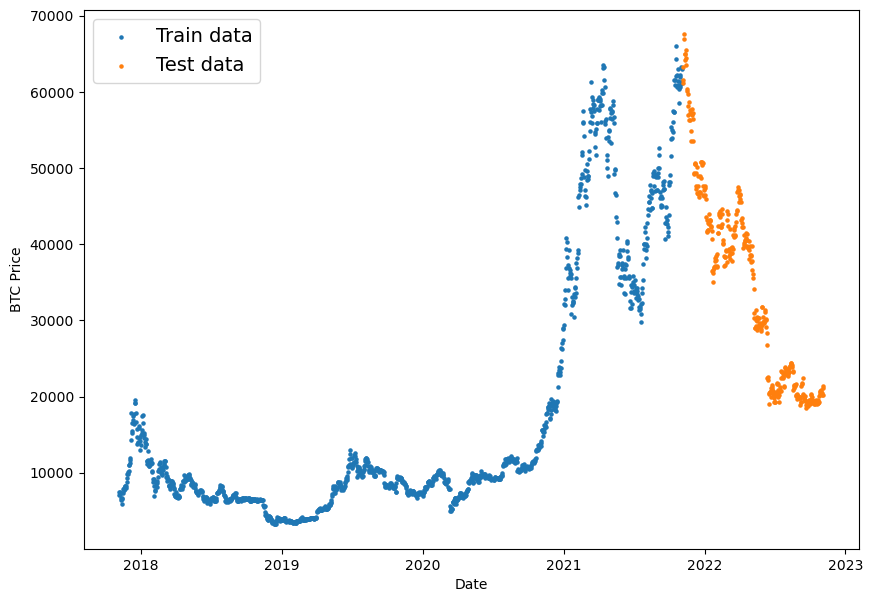

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [11]:
import tensorflow as tf
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [13]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [14]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [16]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) 
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [17]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.05054442 -0.33416063  0.2226625   0.17537022  0.09096466  0.7814104
  0.1680995 ]
Forecast: -0.0796271488070488


In [18]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2017-11-12,5950.069824,6357.600098,6618.140137,7143.580078,7459.689941,7144.379883,7022.759766,7407.410156
2017-11-13,6559.490234,5950.069824,6357.600098,6618.140137,7143.580078,7459.689941,7144.379883,7022.759766
2017-11-14,6635.750000,6559.490234,5950.069824,6357.600098,6618.140137,7143.580078,7459.689941,7144.379883
2017-11-15,7315.540039,6635.750000,6559.490234,5950.069824,6357.600098,6618.140137,7143.580078,7459.689941
2017-11-16,7871.689941,7315.540039,6635.750000,6559.490234,5950.069824,6357.600098,6618.140137,7143.580078


In [19]:
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1456, 1456, 364, 364)

In [20]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [22]:
#N-beats hyperparams setting
N_EPOCHS = 5000 
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [25]:
#Setting up double residual stacking system
from tensorflow.keras import layers
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = layers.subtract([tensor_1, tensor_2])

added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [26]:
%%time

tf.random.set_seed(42)


nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")


stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")


backcast, forecast = nbeats_block_layer(stack_input)
 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 


for i, _ in enumerate(range(N_STACKS-1)): 

 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)


  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")


model_N = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")


model_N.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])


model_N.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 137: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 237: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: total: 1h 5min 50s
Wall time: 10min 1s


In [37]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          }

In [38]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [39]:
model_N.evaluate(test_dataset)

1/1 [==============================] - 0s 305ms/step - loss: 853.6624 - mae: 853.6624 - mse: 1566169.0000


[853.6624145507812, 853.6624145507812, 1566169.0]

In [40]:
model_N_preds = make_preds(model_N, test_dataset)
model_N_preds[:10]

1/1 [==============================] - 0s 301ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([61374.492, 62621.703, 66414.15 , 66978.836, 65575.24 , 64964.484,
       63940.3  , 64140.34 , 65141.05 , 63853.92 ], dtype=float32)>

In [41]:
model_N_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_N_preds)
model_N_results

{'mae': 853.6624, 'mse': 1566169.0, 'rmse': 1251.4668, 'mape': 2.49649}